# Word2Vec (Negative Sampling)

# Importing Libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
np.__version__, torch.__version__

('1.25.2', '2.1.0')

In [3]:
import matplotlib
matplotlib.__version__

'3.7.2'

## 1. Load data

In [8]:
with open ("./data.txt", "r") as doc:
    corpus = doc.read()

In [9]:
corpus

'It is a truth universally acknowledged, that a single man in possession of a good fortune, must be in want of a wife. However little known the feelings or views of such a man may be on his first entering a neighbourhood, this truth is so well fixed in the minds of the surrounding families, that he is considered as the rightful property of some one or other of their daughters.'

In [10]:
#1. tokenization
corpus = [corpus.split(" ") for sent in corpus]
corpus[0:5000]

[['It',
  'is',
  'a',
  'truth',
  'universally',
  'acknowledged,',
  'that',
  'a',
  'single',
  'man',
  'in',
  'possession',
  'of',
  'a',
  'good',
  'fortune,',
  'must',
  'be',
  'in',
  'want',
  'of',
  'a',
  'wife.',
  'However',
  'little',
  'known',
  'the',
  'feelings',
  'or',
  'views',
  'of',
  'such',
  'a',
  'man',
  'may',
  'be',
  'on',
  'his',
  'first',
  'entering',
  'a',
  'neighbourhood,',
  'this',
  'truth',
  'is',
  'so',
  'well',
  'fixed',
  'in',
  'the',
  'minds',
  'of',
  'the',
  'surrounding',
  'families,',
  'that',
  'he',
  'is',
  'considered',
  'as',
  'the',
  'rightful',
  'property',
  'of',
  'some',
  'one',
  'or',
  'other',
  'of',
  'their',
  'daughters.'],
 ['It',
  'is',
  'a',
  'truth',
  'universally',
  'acknowledged,',
  'that',
  'a',
  'single',
  'man',
  'in',
  'possession',
  'of',
  'a',
  'good',
  'fortune,',
  'must',
  'be',
  'in',
  'want',
  'of',
  'a',
  'wife.',
  'However',
  'little',
  'know

In [11]:
#2. numeralization
#find unique words
flatten = lambda l: [item for sublist in l for item in sublist]
#assign unique integer
vocabs = list(set(flatten(corpus))) #all the words we have in the system - <UNK>

In [13]:
#create handy mapping between integer and word
word2index = {v:idx for idx, v in enumerate(vocabs)}
word2index

{'such': 0,
 'minds': 1,
 'possession': 2,
 'considered': 3,
 'fortune,': 4,
 'be': 5,
 'must': 6,
 'feelings': 7,
 'his': 8,
 'or': 9,
 'acknowledged,': 10,
 'well': 11,
 'known': 12,
 'a': 13,
 'truth': 14,
 'one': 15,
 'he': 16,
 'first': 17,
 'daughters.': 18,
 'However': 19,
 'little': 20,
 'their': 21,
 'as': 22,
 'the': 23,
 'universally': 24,
 'is': 25,
 'man': 26,
 'It': 27,
 'may': 28,
 'this': 29,
 'want': 30,
 'views': 31,
 'some': 32,
 'fixed': 33,
 'that': 34,
 'wife.': 35,
 'in': 36,
 'on': 37,
 'entering': 38,
 'good': 39,
 'surrounding': 40,
 'of': 41,
 'neighbourhood,': 42,
 'other': 43,
 'property': 44,
 'rightful': 45,
 'so': 46,
 'single': 47,
 'families,': 48}

In [14]:
vocabs.append('<UNK>')
word2index['<UNK>'] = 6

In [16]:
index2word = {v:k for k, v in word2index.items()}
index2word[8]

'his'

## 2. Prepare train data

In [17]:

def random_batch(batch_size, corpus):

    skipgrams = []

    #loop each corpus
    for doc in corpus:
        #look from the 2nd word until second last word
        for i in range(1, len(doc)-1):
            #center word
            center = word2index[doc[i]]
            #outside words = 2 words
            outside = (word2index[doc[i-1]], word2index[doc[i+1]])
            #for each of these two outside words, we gonna append to a list
            for each_out in outside:
                skipgrams.append([center, each_out])
                #center, outside1;   center, outside2
                
    random_index = np.random.choice(range(len(skipgrams)), batch_size, replace=False)
    
    inputs, labels = [], []
    for index in random_index:
        inputs.append([skipgrams[index][0]])
        labels.append([skipgrams[index][1]])
        
    return np.array(inputs), np.array(labels)

In [18]:
#testing the method
batch_size = 2 # mini-batch size
input_batch, target_batch = random_batch(batch_size, corpus)

print("Input: ", input_batch)
print("Target: ", target_batch)

Input:  [[ 9]
 [17]]
Target:  [[31]
 [ 8]]


## 3. Negative Sampling

### Unigram distribution

$$P(w)=U(w)^{3/4}/Z$$

In [19]:
z = 0.001

In [20]:
#count
from collections import Counter

word_count = Counter(flatten(corpus))
word_count

#get the total number of words
num_total_words = sum([c for w, c in word_count.items()])
num_total_words

26838

In [22]:
vocabs[:10]

['such',
 'minds',
 'possession',
 'considered',
 'fortune,',
 'be',
 'must',
 'feelings',
 'his',
 'or']

$$P(w)=U(w)^{3/4}/Z$$

In [23]:
unigram_table = []

for v in vocabs:
    uw = word_count[v] / num_total_words
    uw_alpha = int((uw ** 0.75) / z)
    unigram_table.extend([v] * uw_alpha)
    
Counter(unigram_table)

Counter({'a': 156,
         'of': 156,
         'the': 115,
         'is': 93,
         'in': 93,
         'be': 68,
         'or': 68,
         'truth': 68,
         'man': 68,
         'that': 68,
         'such': 40,
         'minds': 40,
         'possession': 40,
         'considered': 40,
         'fortune,': 40,
         'must': 40,
         'feelings': 40,
         'his': 40,
         'acknowledged,': 40,
         'well': 40,
         'known': 40,
         'one': 40,
         'he': 40,
         'first': 40,
         'daughters.': 40,
         'However': 40,
         'little': 40,
         'their': 40,
         'as': 40,
         'universally': 40,
         'It': 40,
         'may': 40,
         'this': 40,
         'want': 40,
         'views': 40,
         'some': 40,
         'fixed': 40,
         'wife.': 40,
         'on': 40,
         'entering': 40,
         'good': 40,
         'surrounding': 40,
         'neighbourhood,': 40,
         'other': 40,
         'property': 4

## 4. Model

$$\mathbf{J}_{\text{neg-sample}}(\mathbf{v}_c,o,\mathbf{U})=-\log(\sigma(\mathbf{u}_o^T\mathbf{v}_c))-\sum_{k=1}^K\log(\sigma(-\mathbf{u}_k^T\mathbf{v}_c))$$

In [26]:
def prepare_sequence(seq, word2index):
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index['<UNK>'], seq))
    return torch.LongTensor(idxs)

#use for the normalized term in the probability calculation
all_vocabs = prepare_sequence(list(vocabs), word2index).expand(batch_size, len(vocabs))  # [batch_size, voc_size]
all_vocabs.shape

torch.Size([2, 50])

In [27]:
import random

def negative_sampling(targets, unigram_table, k):
    batch_size = targets.shape[0]
    neg_samples = []
    for i in range(batch_size):  #(1, k)
        target_index = targets[i].item()
        nsample      = []
        while (len(nsample) < k):
            neg = random.choice(unigram_table)
            if word2index[neg] == target_index:
                continue
            nsample.append(neg)
        neg_samples.append(prepare_sequence(nsample, word2index).reshape(1, -1))
        
    return torch.cat(neg_samples) #batch_size, k

In [28]:
batch_size = 2
x, y = random_batch(batch_size, corpus)
x_tensor = torch.LongTensor(x)
y_tensor = torch.LongTensor(y)

In [29]:
k = 5
neg_samples = negative_sampling(y_tensor, unigram_table, k)

In [30]:
y_tensor[1]

tensor([41])

In [31]:
neg_samples[1]

tensor([ 8, 36, 13, 43, 25])

$$\mathbf{J}_{\text{neg-sample}}(\mathbf{v}_c,o,\mathbf{U})=-\log(\sigma(\mathbf{u}_o^T\mathbf{v}_c))-\sum_{k=1}^K\log(\sigma(-\mathbf{u}_k^T\mathbf{v}_c))$$

In [32]:
class SkipgramNeg(nn.Module):
    
    def __init__(self, voc_size, emb_size):
        super(SkipgramNeg, self).__init__()
        self.embedding_center  = nn.Embedding(voc_size, emb_size)
        self.embedding_outside = nn.Embedding(voc_size, emb_size)
        self.logsigmoid        = nn.LogSigmoid()
    
    def forward(self, center, outside, negative):
        #center, outside:  (bs, 1)
        #negative       :  (bs, k)
        
        center_embed   = self.embedding_center(center) #(bs, 1, emb_size)
        outside_embed  = self.embedding_outside(outside) #(bs, 1, emb_size)
        negative_embed = self.embedding_outside(negative) #(bs, k, emb_size)
        
        uovc           = outside_embed.bmm(center_embed.transpose(1, 2)).squeeze(2) #(bs, 1)
        ukvc           = -negative_embed.bmm(center_embed.transpose(1, 2)).squeeze(2) #(bs, k)
        ukvc_sum       = torch.sum(ukvc, 1).reshape(-1, 1) #(bs, 1)
        
        loss           = self.logsigmoid(uovc) + self.logsigmoid(ukvc_sum)
        
        return -torch.mean(loss)

In [33]:
def get_embed(self, word):
    id_tensor = torch.LongTensor([word2index[word]])
    
    v_embed = self.embedding_center(id_tensor)
    u_embed = self.embedding_outside(id_tensor)
    
    word_embed = (v_embed + u_embed) / 2

    return word_embed


In [34]:
#test your model
emb_size = 2
voc_size = len(vocabs)
model = SkipgramNeg(voc_size, emb_size)

In [35]:
loss = model(x_tensor, y_tensor, neg_samples)

In [36]:
loss

tensor(1.7907, grad_fn=<NegBackward0>)

## 5. Training

In [37]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [38]:
import time

num_epochs = 5000

for epoch in range(num_epochs):
    epoch_start_time = time.time()

    input_batch, label_batch = random_batch(batch_size, corpus)
    input_tensor = torch.LongTensor(input_batch)
    label_tensor = torch.LongTensor(label_batch)

    neg_samples = negative_sampling(label_tensor, unigram_table, k)
    loss = model(input_tensor, label_tensor, neg_samples)

    # backpropagate
    optimizer.zero_grad()
    loss.backward()

    # update alpha
    optimizer.step()

    # Record the end time for each epoch
    epoch_end_time = time.time()

    # Calculate epoch time
    epoch_time = epoch_end_time - epoch_start_time

    # print the loss and epoch time
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch {epoch+1:6.0f} | Loss: {loss:2.6f} | Epoch Time: {epoch_time:.2f} seconds")


Epoch   1000 | Loss: 0.712110 | Epoch Time: 0.01 seconds
Epoch   2000 | Loss: 2.051897 | Epoch Time: 0.05 seconds
Epoch   3000 | Loss: 1.252368 | Epoch Time: 0.05 seconds
Epoch   4000 | Loss: 1.258939 | Epoch Time: 0.01 seconds
Epoch   5000 | Loss: 1.103274 | Epoch Time: 0.05 seconds


In [54]:
print(f'Training Loss: {loss}')

Training Loss: 1.1032737493515015


In [55]:
# Saving the model for testing
torch.save(model.state_dict(), 'app/models/Word2vecSkipgramNeg-v1.pt')

## 6. Plot the embeddings

In [40]:
vocabs[:10]

['such',
 'minds',
 'possession',
 'considered',
 'fortune,',
 'be',
 'must',
 'feelings',
 'his',
 'or']

In [41]:
possession = torch.LongTensor([word2index['possession']])
possession

tensor([2])

In [42]:
possession_embed_c = model.embedding_center(possession)
possession_embed_o = model.embedding_outside(possession)
possession_embed   = (possession_embed_c + possession_embed_o) / 2
possession_embed

tensor([[ 0.6273, -0.1826]], grad_fn=<DivBackward0>)

In [43]:
possession_embed_o

tensor([[ 0.3439, -0.0273]], grad_fn=<EmbeddingBackward0>)

In [44]:
def get_embed(word):
    try:
        index = word2index[word]
    except:
        index = word2index['<UNK>']
        
    word = torch.LongTensor([word2index[word]])
    
    embed_c = model.embedding_center(word)
    embed_o = model.embedding_outside(word)
    embed   = (embed_c + embed_o) / 2
    
    return embed[0][0].item(), embed[0][1].item()

In [48]:
get_embed('fortune,')

(0.5671474933624268, -0.11281424760818481)

In [49]:
get_embed('minds')

(0.09883096814155579, -0.002312198281288147)

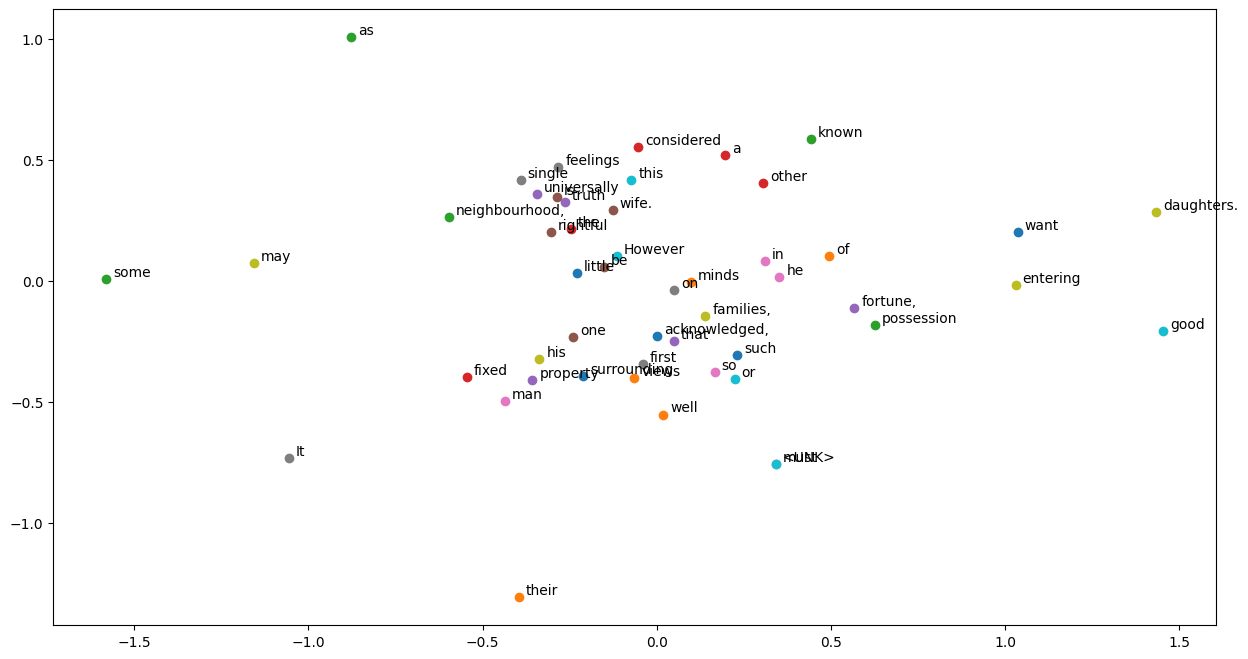

In [52]:
plt.figure(figsize=(15, 8))
for i, word in enumerate(vocabs):
    x, y = get_embed(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

In [56]:
SkipgramNegData = {
    'corpus': corpus,
    'vocab': vocabs,
    'word2index': word2index,
    'voc_size': voc_size,
    'embedding_size': emb_size
}

In [57]:
import pickle
pickle.dump(SkipgramNegData,open('./app/models/SkipgramNegData.pkl', 'wb'))